In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import random
import time
import itertools
from tqdm.notebook import tqdm
tqdm.pandas()



from PIL import Image
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
from spacy import displacy
from collections import Counter
#import hu_core_ud_lg

#nlp = hu_core_ud_lg.load()


from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [20]:
def get_f_score(pipelines,X_train, y_train,X_test, y_test):
    out = {}
    for pipeline in pipelines:
        out[pipeline["name"]] = {
            "train": pipeline["pipeline"].score(X_train, y_train),
            "test": pipeline["pipeline"].score(X_test, y_test),
        }
    return pd.DataFrame(out).T

def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    #print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def build_model(vectorizer, estimators, x, y,min_df=0.0):
    pipelines = []

    if "Count Vectorizer" == vectorizer:
        vec = CountVectorizer(analyzer="word",max_df=0.95,min_df=min_df)
    elif "Tfidf Vectorizer" == vectorizer:
        vec = TfidfVectorizer(analyzer="word",max_df=1.0,min_df=min_df)


    vec.fit(x)

    for name in estimators:
        print("train %s" % name)

        if name == "Logistic Regression":
            estimator = LogisticRegressionCV(solver="newton-cg", n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == "One vs Rest":
            base_estimator = LogisticRegression(solver="newton-cg", n_jobs=-1)
            estimator = OneVsRestClassifier(base_estimator)
            pipeline = make_pipeline(vec, estimator)
        elif name == "Random Forest":
            estimator = RandomForestClassifier(n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == "Support Vector Classifier":
            estimator = SVC(kernel="linear",gamma="auto",probability=True)
            pipeline = make_pipeline(vec, estimator)
        elif name == "Multinomial Naive Bayes":
            estimator = MultinomialNB()
            pipeline = make_pipeline(vec, estimator)
        elif name == "XGBoost Classifier":
            estimator = xgb.XGBClassifier()
            pipeline = make_pipeline(vec, estimator)

        pipeline.fit(x, y)
        pipelines.append({"name": name, "pipeline": pipeline})

    return pipelines, vec

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
swords = stopwords.words('hungarian') + ["ő","ha"]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def text_process(tex, swords=swords):

    document = nlp(tex)
    tex = " ".join([ent.text for ent in document if not ent.ent_type_])
    step_1 = lemmatizer(tex)  # lemmatization by spacy hungarian
    step_2 = "".join(
        [char for char in step_1 if char not in string.punctuation]
    )  # removing special characters

    step_3 = [
        word for word in step_2.split() if word.lower() not in swords
    ]  # removing stopwords by

    step_4 = [word.lower() for word in step_3 if not word.isdigit()]  # removing digits

    text_return = " ".join(step_4)  # concating the text

    return text_return

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## All sites explanatory

In [3]:
df = pd.read_pickle("data/all_site_2020.pkl")

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df.groupby("page")["author"].nunique()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


page
24.hu     162
444       104
888       190
Index    1699
mno       940
origo     125
Name: author, dtype: int64

## Read data

In [8]:
data = pd.read_pickle("data/24_cleaned.pkl")

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
data["author"].value_counts().head(10)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


24.hu                     14021
Kolontár Krisztián         2347
Kovács-Angel Marianna      1852
Vaskor Máté                1834
Farkas György              1763
Dömös Zsuzsanna            1382
Kálmán Attila              1248
Besenyei Balázs            1240
Gégény-Blonszki Renáta     1215
Nagy Nikoletta             1005
Name: author, dtype: int64

In [62]:
data["category"].value_counts()

belfold       12037
kulfold        7473
szorakozas     4891
kultura        3634
tudomany       2904
tech           2337
fn             2055
kozelet        1425
otthon          245
poszt-itt        29
sport             1
Name: category, dtype: int64

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


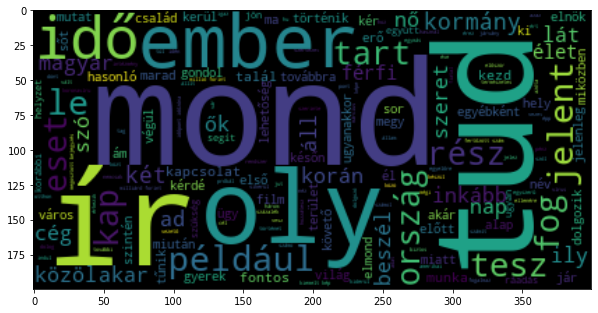

In [12]:
a = " ".join(data["processed_text"].values)

fig, ax = plt.subplots(figsize=(10, 8))

wordcloud = WordCloud().generate(a)
plt.imshow(wordcloud, interpolation='bilinear')

In [14]:
tfidfvectorizer = TfidfVectorizer(analyzer="word",min_df=0.02)

tfidf_wm = tfidfvectorizer.fit_transform(data["processed_text"])

tfidf_tokens = tfidfvectorizer.fit(data["processed_text"]).get_feature_names()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
df_tfidfvect = pd.DataFrame(data = tfidf_wm.todense(), sindex = data.index, columns = tfidf_tokens)

df_tfidfvect

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ad,adat,addig,adott,ajánl,akad,akar,akció,aktív,akár,...,újságíró,út,ügy,ügyészség,ül,ülés,üzenet,üzlet,ők,őrizet
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.254658,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.115891,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.082665,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.099023,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.124115,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37445,0.025380,0.014771,0.000000,0.020283,0.0,0.023599,0.030212,0.0,0.000000,0.015906,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.057816,0.0
37446,0.060508,0.000000,0.093074,0.000000,0.0,0.112524,0.000000,0.0,0.000000,0.075840,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
37447,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
37448,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.04495,0.0,0.0,0.059104,0.0,0.0,0.000000,0.0


In [43]:
countvectorizer = CountVectorizer(analyzer="word",max_df=0.95,min_df=0.05)

count_wm = countvectorizer.fit_transform(df_top["processed_text"])

count_tokens = countvectorizer.fit(df_top["processed_text"]).get_feature_names()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
df_countvect = pd.DataFrame(data = count_wm.todense(),index = df_top.index,columns = count_tokens)

df_countvect

,24hu,ad,adat,addig,akar,akár,alakul,alap,alkalom,alá,...,éves,ír,óra,óta,összes,összesen,öt,út,ügy,ők
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [140]:
df = sample.copy()

In [169]:
df = data.copy()

In [170]:
number_of_authors = 6
top_author = df["author"].value_counts().iloc[1 : number_of_authors + 1].index
print(top_author)

df_top = df.loc[df["author"].isin(top_author)].reset_index(drop=True)

labelencoder = LabelEncoder()
df_top['author_labeled'] = labelencoder.fit_transform(df_top["author"])

Index(['Kolontár Krisztián', 'Kovács-Angel Marianna', 'Vaskor Máté',
       'Farkas György', 'Dömös Zsuzsanna', 'Kálmán Attila'],
      dtype='object')


In [173]:
df_top["processed_text"] = df_top["text"].progress_apply(text_process)

In [190]:
df_top.to_pickle("data/top6_24hu_clean.pkl")

## read clean data

In [9]:
df_top = pd.read_pickle("data/top6_24hu_clean.pkl")

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_top["word_count"] = df_top["processed_text"].str.split(" ").apply(len)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


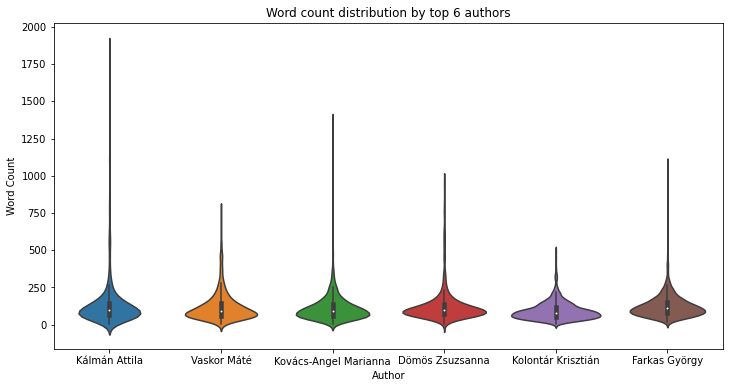

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(x="author", y="word_count", data=df_top, ax=axes)
plt.xlabel("Author")
plt.ylabel("Word Count")
plt.title("Word count distribution by top 6 authors")
plt.show()

In [12]:
df_top = df_top.loc[df_top["word_count"]<600]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df_top = df_top.loc[df_top["date"].sort_values().index,:]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
train_dates = df_top["date"].unique()[: int(df_top["date"].nunique() * 0.8)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
print(train_dates)

['2020-01-01' '2020-01-02' '2020-01-03' '2020-01-04' '2020-01-05'
 '2020-01-06' '2020-01-07' '2020-01-08' '2020-01-09' '2020-01-10'
 '2020-01-12' '2020-01-13' '2020-01-14' '2020-01-15' '2020-01-16'
 '2020-01-17' '2020-01-18' '2020-01-20' '2020-01-21' '2020-01-22'
 '2020-01-23' '2020-01-24' '2020-01-25' '2020-01-26' '2020-01-27'
 '2020-01-28' '2020-01-29' '2020-01-30' '2020-01-31' '2020-02-01'
 '2020-02-02' '2020-02-03' '2020-02-04' '2020-02-05' '2020-02-06'
 '2020-02-07' '2020-02-08' '2020-02-10' '2020-02-11' '2020-02-12'
 '2020-02-13' '2020-02-14' '2020-02-15' '2020-02-16' '2020-02-17'
 '2020-02-18' '2020-02-19' '2020-02-20' '2020-02-21' '2020-02-24'
 '2020-02-25' '2020-02-26' '2020-02-27' '2020-02-28' '2020-02-29'
 '2020-03-01' '2020-03-02' '2020-03-03' '2020-03-04' '2020-03-05'
 '2020-03-06' '2020-03-07' '2020-03-09' '2020-03-10' '2020-03-11'
 '2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15' '2020-03-16'
 '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21'
 '2020-03-

In [16]:
X_train = df_top.loc[df_top["date"].isin(train_dates),"processed_text"]
X_test = df_top.loc[~df_top["date"].isin(train_dates),"processed_text"].reset_index(drop=True)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
y_train = df_top.loc[df_top["date"].isin(train_dates),"author_labeled"]
y_test = df_top.loc[~df_top["date"].isin(train_dates),"author_labeled"].reset_index(drop=True)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
vectorizer = "Count Vectorizer"

estimators = [
    "Logistic Regression",
    "One vs Rest",
    "Random Forest",
    "Support Vector Classifier",
    "Multinomial Naive Bayes",
    "XGBoost Classifier",
]

pipelines, vec = build_model(vectorizer, estimators, X_train, y_train)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
train Logistic Regression


NameError: name 'LogisticRegressionCV' is not defined

In [ ]:
get_f_score(pipelines,X_train, y_train,X_test, y_test)

In [27]:
vectorizer = "Tfidf Vectorizer"

estimators = [
    "Logistic Regression",
    "One vs Rest",
    "Random Forest",
    "Support Vector Classifier",
    "Multinomial Naive Bayes",
    "XGBoost Classifier",
]

pipelines, vec = build_model(vectorizer, estimators, X_train, y_train,min_df=0.05)

train Logistic Regression
train One vs Rest
train Random Forest
train Support Vector Classifier
train Multinomial Naive Bayes
train XGBoost Classifier


In [25]:
import eli5
eli5.show_weights(pipelines[0]["pipeline"][1], vec=vec, top=20)

In [ ]:
pipelines[3]["pipeline"][1]

In [ ]:
test_df.loc[0,"processed_text"]

In [ ]:
from eli5.lime import TextExplainer

doc = test_df.loc[0,"processed_text"]
pipe = pipelines[0]["pipeline"][1]

te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)

In [151]:
test_df = pd.concat([X_test,y_test],axis=1)

y_preds = pipelines[0]["pipeline"].predict(test_df["processed_text"])
test_df['predicted_label'] = y_preds
misclassified_examples = test_df[(test_df['author_labeled']!=test_df['predicted_label'])&(test_df['author_labeled']==4)&(test_df['predicted_label']==2)]
eli5.show_prediction(pipelines[0]["pipeline"][1], misclassified_examples['processed_text'].values[0], vec=vec)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
print("F score")
get_f_score(pipelines,X_train, y_train,X_test, y_test)

F score


,train,test
Logistic Regression,0.686690,0.604520
One vs Rest,0.668847,0.594761
Random Forest,0.999643,0.595788
Support Vector Classifier,0.694183,0.604520
Multinomial Naive Bayes,0.603545,0.552131
XGBoost Classifier,0.986321,0.610169


In [137]:
# getting the predictions of the Validation Set...
predictions = pipelines[0]["pipeline"].predict(X_test)
# getting the Precision, Recall, F1-Score
print(classification_report(y_test,predictions))

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       239
           1       0.50      0.56      0.52       304
           2       0.79      0.94      0.86       397
           3       0.54      0.53      0.54       388
           4       0.47      0.24      0.32       284
           5       0.47      0.48      0.47       335

    accuracy                           0.60      1947
   macro avg       0.59      0.60      0.58      1947
weighted avg       0.59      0.60      0.59      1947



In [138]:
names = df_top.drop_duplicates(subset=["author"])[["author", "author_labeled"]].sort_values(
    by="author_labeled"
)["author"].values

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Normalized confusion matrix


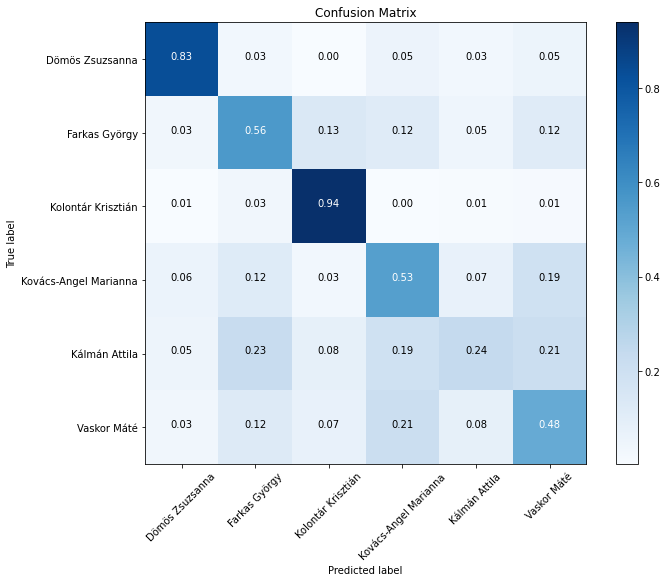

In [139]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(cm, classes=names, normalize=True, title="Confusion Matrix")